In [95]:
import pandas as pd
import numpy as np
import json
from datetime import datetime

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.offline import plot
from plotly.graph_objs import Scatter, Data, Box, Bar
from plotly.graph_objs import Scattergl
init_notebook_mode() # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook

%matplotlib inline
import matplotlib as plt
plt.style.use('ggplot')
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')

# Get JSON data from EtherScan.io API

In [4]:
import urllib3, json, certifi
import pandas as pd
import shutil

def transactions():
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',  # Force certificate check.
                               ca_certs=certifi.where(),  # Path to the Certifi bundle.
                               )

    dao_address = '0xbb9bc244d798123fde783fcc1c72d3bb8c189413'
    etherscan_url = 'https://api.etherscan.io/api?module=account&action=txlist&address=' + dao_address + '&sort=asc'

    with open('sample.json', 'w') as f, http.request('GET', etherscan_url, preload_content=False) as r:
        string_r = r.data.decode('utf-8')
        obj = json.loads(string_r)
        json.dump(obj, f, sort_keys=True, indent=4)
    print(obj['message'])

transactions()

OK


#  Load Transactions from .json

In [2]:
jsondata = pd.read_json("sample.json")
jsondata.head()

,message,result,status
0,OK,"{'cumulativeGasUsed': '47080', 'contractAddres...",1
1,OK,"{'cumulativeGasUsed': '136160', 'contractAddre...",1
2,OK,"{'cumulativeGasUsed': '68080', 'contractAddres...",1
3,OK,"{'cumulativeGasUsed': '199599', 'contractAddre...",1
4,OK,"{'cumulativeGasUsed': '246679', 'contractAddre...",1


In [147]:
jsondata.result[10000]

{'blockHash': '0x8d2a0440bb5a78f075ee906eb661fcff85e2a84e935791c5e55460187f63c395',
 'blockNumber': '1458293',
 'confirmations': '59413',
 'contractAddress': '',
 'cumulativeGasUsed': '44091',
 'from': '0x9e49df12d7b2636508fff7b666736a5c9b12a2d9',
 'gas': '144091',
 'gasPrice': '20000000000',
 'gasUsed': '44091',
 'hash': '0x9c3b35b3f23e83c1b095fa594e09c57f18453ec12ec4fd73aac781be900c7ca9',
 'input': '0x',
 'nonce': '2',
 'timeStamp': '1462404332',
 'to': '0xbb9bc244d798123fde783fcc1c72d3bb8c189413',
 'transactionIndex': '0',
 'value': '2000000000000000000000'}

In [3]:
trans = pd.DataFrame(dict(jsondata.result))
trans = trans.transpose()
trans['value'] = trans.value.astype(float)
trans['blockNumber'] = trans.blockNumber.astype(int)
trans['value_ether'] = trans.value / 1e18
trans['gasPrice'] = trans.gasPrice.astype(float)
trans['gasUsed'] = trans.gasUsed.astype(float)
trans['value_cum'] = trans.value_ether.cumsum()
trans.cumulativeGasUsed = trans.cumulativeGasUsed.astype(float)
# Note the final block of the 1 ETH to 100 tokens
blockEnd_phaseOne = 1520860
# Only get transactions up to this block, ignore the rest
trans = trans[trans.blockNumber <= 1520860]
trans.head()

,blockHash,blockNumber,confirmations,contractAddress,cumulativeGasUsed,from,gas,gasPrice,gasUsed,hash,input,nonce,timeStamp,to,transactionIndex,value,value_ether,value_cum
0,0x9a9d1fc252e816fd047b85b6c1028317ecc0bf3db18d...,1429008,102058,,47080.0,0x931f12be72a1d106408af5ced7e1b7af0bc864ae,49900,2.000000e+10,47080.0,0x18aa650060a1434310a05824e1df6e29a6904f29839e...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984277,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,0,0.0,0.0,0.0
1,0x9a9d1fc252e816fd047b85b6c1028317ecc0bf3db18d...,1429008,102058,,136160.0,0xb504e60998c6f354a0794abd91d85e8bc8436211,49900,2.000000e+10,47080.0,0xe71a87b83e054f616e8b1f4884b905d9a347b64433bb...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984277,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,3,0.0,0.0,0.0
2,0x41a0f3f494329c60c88ae92bf6fc6f35c389e27f53f3...,1429009,102057,,68080.0,0xe0b8bdfddba2b1636c9a975f9e9759169fddee45,49900,2.000000e+10,47080.0,0xc750552b741c499b073dc58d7148c0e8f24c9b4e0a94...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984318,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,1,0.0,0.0,0.0
3,0x41a0f3f494329c60c88ae92bf6fc6f35c389e27f53f3...,1429009,102057,,199599.0,0x2c30cdad7abdeedb44657a7b46827fc38af12203,49900,2.000000e+10,47080.0,0x7a47fdb185d89ab843e71d53702b6ea172378007cf12...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984318,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,5,0.0,0.0,0.0
4,0x41a0f3f494329c60c88ae92bf6fc6f35c389e27f53f3...,1429009,102057,,246679.0,0xd97fdc4af28008c219639401f661369b704e7bbc,49900,2.000000e+10,47080.0,0x5ab9ac02611a1f0652706e4f43515840d1dc33a22b87...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984318,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,6,0.0,0.0,0.0


# How much ether total?

In [4]:
EthToBtc = 0.025
BtcToUsd = 456.25

In [5]:
total_ether = trans.value_ether.sum()
print('ETH {} '.format(total_ether))
print('BTC {}'.format(total_ether * EthToBtc))
print('USD {}'.format(total_ether * EthToBtc * BtcToUsd))

ETH 10264539.206572307 
BTC 256613.4801643077
USD 117079900.32496539


# How many total transactions and unique addresses?

In [6]:
total_transactions = len(trans)
total_transactions

42024

In [7]:
total_addresses = len(trans['from'].unique())
total_addresses

14408

In [8]:
trans.value_ether.describe()

count     42024.000000
mean        244.254217
std        2250.690264
min           0.000000
25%           1.000000
50%          10.000000
75%          85.000000
max      201911.999580
Name: value_ether, dtype: float64

In [109]:
trace = go.Scatter(
    x=trans.blockNumber, 
    y=trans.value_cum,
    name='Transaction Values',
)
data = [trace]
layout = go.Layout(
    title="Cummulative Transaction Volume",
    xaxis=go.XAxis(
        title='Block number',
    ),
    yaxis=go.YAxis(
        title='Amount inversted (Ether)',
    ),
)
fig = go.Figure(data=data, layout=layout)

# iplot(fig)
py.iplot(fig, filename='DAO_plots/cummulative_trans')

/Users/coreypetty/anaconda/lib/python3.5/site-packages/plotly/plotly/plotly.py:236: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/Users/coreypetty/anaconda/lib/python3.5/site-packages/plotly/plotly/plotly.py:1416: UserWarning:

Estimated Draw Time Slow



The draw time for this plot will be slow for clients without much RAM.


# Looking at the number of transactions per address

In [30]:
trans_comb_add = trans.groupby('from').value_ether.sum()
trans_comb_add = pd.DataFrame(trans_comb_add.reset_index())
trans_comb_add.columns = ['from', 'value_ether']
num_trans_per_address = trans.groupby('from').size().sort_values().reset_index()
num_trans_per_address.columns = ['from','num_trans']
num_trans_per_address.head()

,from,num_trans
0,0x0000000000015b23c7e20b0ea5ebd84c39dcbe60,1
1,0x93f0be9a83ef97d3322da92e7bf6844bbecbd14b,1
2,0x93f4659d5dc0b53cfa51c9af3c444b433b51e290,1
3,0x93f8cee77a762bf62c5e939b4a8c5a2d9bcbee6e,1
4,0x9405da0a90fe7af4f8846492fd51e1a54e7380bc,1


In [77]:
num_trans_per_address.num_trans.describe()

count    14408.000000
mean         2.916713
std         39.000526
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       3406.000000
Name: num_trans, dtype: float64

In [81]:
num_trans_per_address[num_trans_per_address.num_trans > 100]

,from,num_trans
14401,0x391fc9c9663a61eeb3dc267e4fe9d4188ee7c1b8,206
14402,0x2910543af39aba0cd09dbb2d50200b3e800a63d2,209
14403,0x9e6316f44baeeee5d41a1070516cc5fa47baf227,538
14404,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,843
14405,0xf0e42abda410cefb5b4dc4de92a3de5b309e02f2,1004
14406,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,2859
14407,0x32be343b94f860124dc4fee278fdcbd38c102d88,3406


# How much ether has been paid to miners by funding the DAO?

In [29]:
trans['gasUsedInEther'] = trans.gasUsed / trans.gasPrice
trans['gasUsedInEther'].sum()

0.10636110913467833

# Lets look a the distribution of investments.

In [32]:
def label_exp_group(value):
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
    for label in labels:
        if value <= 10**float(label):
            return label

trans['exp_group'] = trans.value_ether.apply(label_exp_group)
trans_comb_add['exp_group'] = trans_comb_add.value_ether.apply(label_exp_group)

In [54]:
print("0      < % accounts < 1      : ", len(trans_comb_add.value_ether[trans_comb_add.value_ether < 1])/total_addresses * 100)
print("1      < % accounts < 10     : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 1) & (trans_comb_add.value_ether < 10)])/total_addresses * 100)
print("10     < % accounts < 100    : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 10) & (trans_comb_add.value_ether < 100)])/total_addresses * 100)
print("100    < % accounts < 1000   : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 100) & (trans_comb_add.value_ether < 1000)])/total_addresses * 100)
print("1000   < % accounts < 10000  : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 1000) & (trans_comb_add.value_ether < 10000)])/total_addresses * 100)
print("10000  < % accounts < 100000 : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 10000) & (trans_comb_add.value_ether < 100000)])/total_addresses * 100)
print("100000 < % accounts          : ", len(trans_comb_add.value_ether[trans_comb_add.value_ether >= 100000])/total_addresses * 100)

0      < % accounts < 1      :  23.81315935591338
1      < % accounts < 10     :  12.874791782343141
10     < % accounts < 100    :  26.3811771238201
100    < % accounts < 1000   :  27.561077179344807
1000   < % accounts < 10000  :  8.176013325930038
10000  < % accounts < 100000 :  1.1313159355913383
100000 < % accounts          :  0.06246529705719045


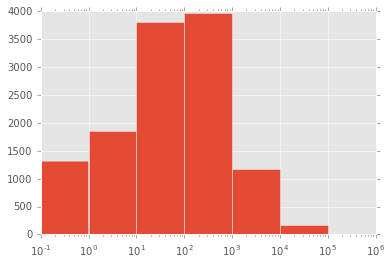

In [46]:
bins = np.logspace(-1, 6, 8)
#bins = 200
fig, ax = plt.pyplot.subplots()
trans_comb_add.value_ether.hist(ax=ax, bins=bins)
ax.set_xscale('log')
# ax.set_yscale('log')

In [102]:
grouped_ether = trans_comb_add.groupby('exp_group').sum()
grouped_accounts = trans_comb_add.groupby('exp_group').size()
grouped_accounts = pd.DataFrame(grouped_accounts, columns=['num_addresses'])

In [103]:
grouped_ether['value_perc'] = grouped_ether.value_ether / total_ether * 100
grouped_accounts['percentage'] = grouped_accounts.num_addresses / total_addresses * 100

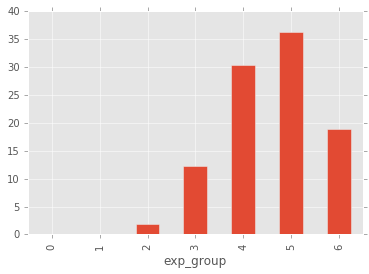

In [93]:
grouped_ether.value_perc.plot(kind='bar')

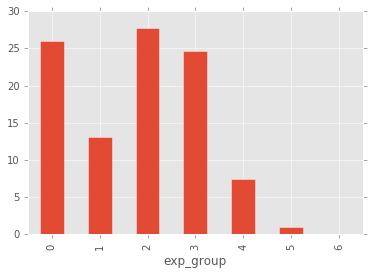

In [94]:
grouped_accounts.percentage.plot(kind='bar')

In [108]:
trace = go.Bar( 
    y=grouped_accounts.percentage,
    name='Total Accounts',
)
trace2 = go.Bar( 
    y=grouped_ether.value_perc,
    name='Total Ether Held',
)
data = Data([trace, trace2])
layout = go.Layout(
    xaxis=go.XAxis(
        title='Investor Group',
        ticktext = [
                "$0 < x < 10^0$",
                "$10^0 < x < 10^1$",
                "$10^1 < x < 10^2$",
                "$10^2 < x < 10^3$",
                "$10^3 < x < 10^4$",
                "$10^4 < x < 10^5$",
                "$10^5 < x < 10^6$",
            ],
        tickvals = [ 0, 1, 2, 3, 4, 5, 6 ]
    ),
    yaxis=go.YAxis(
        title='Percentage',
    ),
    legend=dict(
        x=0,
        y=1
    )
)
fig = go.Figure(data=data, layout=layout)

# iplot(fig)
py.iplot(fig, filename='DAO_plots/PercentageAccountsVsPercentageEther')

# Looking at the number of transactions per block

In [326]:
grouped_block = trans.groupby('blockNumber')
grouped_block.groups

{'1499884': [22675],
 '1469089': [12176],
 '1508473': [28378],
 '1447384': [7694],
 '1504871': [25484, 25485, 25486],
 '1430920': [226],
 '1511705': [32068, 32069, 32070, 32071, 32072, 32073],
 '1518194': [39288],
 '1508112': [27880, 27881],
 '1457484': [9843],
 '1515434': [37533, 37534],
 '1518897': [39630],
 '1468101': [11898],
 '1494760': [19901],
 '1438711': [5314, 5315],
 '1521006': [42075],
 '1468434': [11982],
 '1482769': [15652],
 '1497758': [21413],
 '1433334': [2187],
 '1499914': [22706, 22707],
 '1500005': [22796, 22797],
 '1497868': [21469],
 '1504214': [24999],
 '1432992': [1744, 1745],
 '1437335': [4782, 4783],
 '1454008': [9019],
 '1495270': [20078],
 '1460700': [10384],
 '1520637': [41729, 41730, 41731, 41732, 41733, 41734, 41735, 41736],
 '1477153': [13925],
 '1440045': [5764, 5765],
 '1520945': [42054],
 '1458920': [10081],
 '1515566': [37589],
 '1498515': [21806],
 '1465074': [11314],
 '1432613': [1407, 1408, 1409],
 '1433594': [3348, 3349, 3350],
 '1495457': [20148]